In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score


In [2]:
class Encoder():
    def __init__(self, columns):
        self.encoder = None 
        self.col_names = None
        self.columns = columns
        self.values = []
    
    def fit(self, X):
        X = X.loc[:, self.columns].astype(str)
        self.values = [np.unique(X[col]) for col in X] 
        self.encoder = OneHotEncoder(categories=self.values, handle_unknown='ignore')
        
        self.encoder.fit(X)
        col_names = []
        for column, values in zip(self.columns, self.values):
            for value in values:
                
                col_names.append(f'{column}_{value}') 
        self.col_names = col_names 
        
    def transform(self, X):
        ar = self.encoder.transform(X.loc[:, self.columns].astype(str))
        ar = ar.todense()
        X = X.drop(columns=self.columns)
        for i, col in enumerate(self.col_names):
            X[col] = ar[:, i]
        return X
    

### Load in Customer Data

In [3]:
customers = pd.read_csv('data/MFG-customers.csv')
customers = customers.loc[:, ['CustomerID', 'City', 'State', 'Country']]
customers['Location'] = customers['State'].fillna(customers['Country']).apply(lambda x: str(x).upper())
customers['City'] = customers['City'].apply(lambda x: str(x).upper())
customers.drop(columns=['State', 'Country'], inplace=True)
 

### Load in Accounts Data

In [4]:
accounts = pd.read_csv('data/MFG-accounts.csv', usecols=['Account_ID', 'Revenue_Class'])

### Load in Invoices Data

In [5]:
invoices = pd.read_csv('data/MFG-invoices.csv', parse_dates=True)
invoices['Date'] = invoices['Date'].apply(pd.Timestamp)
invoices['Month'] = invoices['Date'].apply(lambda x: x.month)
invoices['Year'] = invoices['Date'].apply(lambda x: x.year)
invoices['Day'] = invoices['Date'].apply(lambda x: x.day)

In [6]:
invoices ['Amount'] = (invoices['Amount'].str.replace(',', '').astype(float)).abs()

In [7]:
invoices['Unit_Price'] = invoices['Unit_Price'].apply(
    lambda x: x.replace(',', '') if isinstance(x, str) else x
).astype(float)
invoices['Amount'] = invoices['Amount'].apply(
    lambda x: x.replace(',', '') if isinstance(x, str) else x
).astype(float)
invoices['Qty'] = invoices['Qty'].apply(
    lambda x: x.replace(',', '') if isinstance(x, str) else x
).astype(float)


### Load in Industry + Press Release Data

In [8]:
industry = pd.read_csv('data/MFG-industry.csv')

In [9]:
press_release = pd.read_csv('data/Press_Release.csv')

In [10]:
press_release['Release Date'] = press_release['Release Date'].apply(pd.Timestamp)
press_release['Month'] = press_release['Release Date'].apply(lambda x: x.month)
press_release['Year'] = press_release['Release Date'].apply(lambda x: x.year)
press_release['Topic_PR'] = press_release['Column1']

In [11]:
press_release.drop(columns=['PR ID', 'Status', 'Last Modified','Premium','Headline', 'Column1'], inplace=True)

In [12]:
press_release.head()

,Hits,Release Date,Month,Year,Topic_PR
0,2716,2010-02-04,2,2010,Simulation
1,1987,2010-10-13,10,2010,Expansion
2,984,2011-11-10,11,2011,Award
3,1968,2011-11-21,11,2011,Award
4,1390,2012-01-18,1,2012,Simulation


In [13]:
press_encoder = Encoder(['Topic_PR'])
press_encoder.fit(press_release)
pr = press_encoder.transform(press_release)
pr = pr.groupby(['Year','Month']).sum().reset_index()

### Create Target Variable

In [14]:
n_days = 90
min_diff_days = 3
repeat=[]
for invoice in invoices.iterrows():
    repeat.append((
        (invoice[1]['CustID'] == invoices['CustID']) 
        & (invoice[1]['Date'] < invoices['Date']) 
        & (invoices['Date'] - invoice[1]['Date'] < pd.Timedelta(n_days, 'd'))
        & (invoices['Date'] - invoice[1]['Date'] > pd.Timedelta(min_diff_days, 'd'))
    ).any())  
    

### Feature Engineering

In [15]:
# days_since_last = invoices.groupby('CustID').apply(lambda x: np.diff(pd.Series.sort_values(x['Date']).values))

In [16]:
first_invoice_date = invoices.groupby('CustID')['Date'].min()
customers['First_Invoice'] = first_invoice_date[customers['CustomerID']].values


#total_cust = invoices.groupby('CustID')['Amount'].sum()
#invoices['Total_cust'] =  total_cust[invoices['CustID']].values

#mean_cust = invoices.groupby('CustID')['Amount'].mean()
#invoices['Mean_cust'] =  mean_cust[invoices['CustID']].values


In [17]:
cumulatives = []
for indx, row in invoices.iterrows():
    custid = row['CustID']
    date = row['Date']
    cumulative=invoices[(invoices['CustID'] == custid)& (invoices['Date']<= date)]['Amount'].sum()
    cumulatives.append(cumulative)

invoices['cumulatives'] = cumulatives

In [18]:
#X.groupby('Revenue_Class')['CustID']
#X.groupby('Item_ID')['CustID']

In [19]:
#press_release.sort_values(['Year', 'Month']).head(20)

### Merge Data

In [20]:
X = invoices.merge(customers, how='left', left_on=['CustID'], right_on=['CustomerID'])
X = X.merge(accounts, how='left', on=['Account_ID'])
X = X.merge(industry, how='left', left_on=['CustID'],right_on=['CustID'])
X = X.merge(pr, how='left', left_on=['Year','Month'], right_on=['Year','Month'])
X.drop(columns=['CustomerID'], inplace=True)
y = pd.Series(repeat, dtype=int)
ids = X['CustID']

In [21]:
#here I used a merge db
total_rev_class = X.groupby('Revenue_Class')['Amount'].agg('sum')
mean_rev_class = X.groupby('Revenue_Class')['Amount'].agg('mean')

In [22]:
#X.drop(columns=['CustID'], inplace=True)

In [23]:
#X.set_index(('CustID'), inplace=True)

In [24]:
#X['ttl_amount_cust'] = total_cust#total_cust.loc[X['CustID'].values].values

In [25]:
cutoff_date = X['Date'].max() - pd.Timedelta(n_days, 'd')

Since we don't have enough data after this date, we can't include it in our training set.

In [26]:
(X['Date'] < cutoff_date).shape

(13349,)

In [27]:
y = y[X['Date'] < cutoff_date]
ids = ids[X['Date'] < cutoff_date]
X = X[X['Date'] < cutoff_date]


X.drop(columns=['Date'], inplace=True)
X.drop(columns=['Day'], inplace=True)

In [28]:
X.shape, y.shape, ids.shape

((12396, 23), (12396,), (12396,))

### Split Data

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [30]:
def clean_nan(X, y, ids):
    X['Item_ID'] = X['Item_ID'].astype(str)
    X['Revenue_Class'] = X['Revenue_Class'].astype(str)
    y = y[~X.isna().any(axis=1)]
    ids = ids[~X.isna().any(axis=1)]
    X.dropna(inplace=True)
    return X, y, ids

In [31]:
X.shape, y.shape, ids.shape,

((12396, 23), (12396,), (12396,))

In [32]:
class Encoder():
    def __init__(self, columns):
        self.encoder = None 
        self.col_names = None
        self.columns = columns
        self.values = []
    
    def fit(self, X):
        X = X.loc[:, self.columns].astype(str)
        self.values = [np.unique(X[col]) for col in X] 
        self.encoder = OneHotEncoder(categories=self.values, handle_unknown='ignore')
        
        self.encoder.fit(X)
        col_names = []
        for column, values in zip(self.columns, self.values):
            for value in values:
                
                col_names.append(f'{column}_{value}') 
        self.col_names = col_names 
        
    def transform(self, X):
        ar = self.encoder.transform(X.loc[:, self.columns].astype(str))
        ar = ar.todense()
        X = X.drop(columns=self.columns)
        for i, col in enumerate(self.col_names):
            X[col] = ar[:, i]
        return X
    

In [33]:
categorical_features = ['Item_ID', 'Month', 'Year', 
                        'Location', 'Revenue_Class',
                        'City', 'Item_ID', 'Account_ID', 
                        'Industry','First_Invoice']

In [34]:
custs = X['CustID'].unique()
cust_train, cust_test = train_test_split(custs)
idx_train = X[X['CustID'].isin(cust_train)].index
idx_test = X[X['CustID'].isin(cust_test)].index

X_train = X.loc[idx_train]
X_test = X.loc[idx_test]

y_train = y.loc[idx_train]
y_test = y.loc[idx_test]

ids_train = ids.loc[idx_train]
ids_test = ids.loc[idx_test]

In [35]:
X_train.shape

(9261, 23)

In [36]:
X_train, y_train, ids_train = clean_nan(X_train, y_train, ids_train)
X_test, y_test, ids_test = clean_nan(X_test, y_test, ids_test)

In [37]:
encoder = Encoder(categorical_features)

In [38]:
encoder.fit(X_train)

In [39]:
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

## Modeling

In [40]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

### Random Forest

In [41]:
rf = RandomForestClassifier(1000)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
log_loss(y_test, rf.predict_proba(X_test)[:, 1])

0.4703365643184408

In [43]:
train_predictions_rf = rf.predict(X_train)
test_predictions_rf = rf.predict_proba(X_test)
train_probas_rf = rf.predict_proba(X_train)
test_probas_rf = rf.predict_proba(X_test)

In [44]:
test_probas_rf = rf.predict_proba(X_test)[:, 1]

In [45]:
threshold = 0.5
model_results_rf = pd.DataFrame(np.column_stack((test_probas_rf,
                                              test_probas_rf >= threshold,
                                              y_test, ids_test)))
model_results_rf.columns = ['probabilities','predictions','actuals','ids']
model_results_rf.head()

,probabilities,predictions,actuals,ids
0,0.557,1.0,1.0,690509.0
1,0.648,1.0,0.0,244733.0
2,0.684,1.0,1.0,330730.0
3,0.501,1.0,0.0,865720.0
4,0.520,1.0,0.0,865720.0


### Gradient Boost

In [53]:
gb = GradientBoostingClassifier(n_estimators=100, max_depth=4)

In [54]:
cross_val_score(gb, X_train, y_train, cv=3, scoring='neg_log_loss')

array([-0.36879077, -0.39764675, -0.41493041])

In [55]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [56]:
log_loss(y_test, gb.predict_proba(X_test)[:, 1])

0.43889298470262605

In [46]:
gb1= GradientBoostingClassifier(n_estimators=4000, max_depth=4)

In [47]:
cross_val_score(gb1, X_train, y_train, cv=3, scoring='neg_log_loss')

array([-1.10795536, -1.39735143, -1.21059955])

In [48]:
gb1.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=4000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [49]:
log_loss(y_test, gb1.predict_proba(X_test)[:, 1])

1.1208997396051714

/Users/lulu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


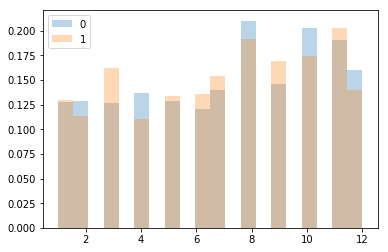

In [50]:
fig, ax = plt.subplots()
ax.hist(X.loc[y==0,'Month'], bins=20, alpha=0.3, label='0', normed=True)
ax.hist(X.loc[y==1,'Month'], bins=20, alpha=0.3, label='1', normed=True)
ax.legend()

In [51]:
np.argmin([log_loss(y_test, y_pred) for y_pred in gb1.staged_predict_proba(X_test)])

100

In [57]:
train_predictions_gb = gb.predict(X_train)
test_predictions_gb = gb.predict_proba(X_test)
train_probas_gb = gb.predict_proba(X_train)
test_probas_gb = gb.predict_proba(X_test)

In [58]:
test_probas_gb = gb.predict_proba(X_test)[:, 1]

In [59]:
threshold = 0.5
model_results_gb = pd.DataFrame(np.column_stack((test_probas_gb,
                                              test_probas_gb >= threshold,
                                              y_test, ids_test)))
model_results_gb.columns = ['probabilities','predictions','actuals','ids']
model_results_gb.head()

,probabilities,predictions,actuals,ids
0,0.470937,0.0,1.0,690509.0
1,0.593508,1.0,0.0,244733.0
2,0.787658,1.0,1.0,330730.0
3,0.497067,0.0,0.0,865720.0
4,0.503570,1.0,0.0,865720.0


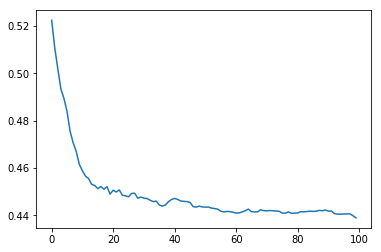

In [60]:
#GradientBoosting
fig, ax = plt.subplots()
ax.plot([log_loss(y_test, y_pred) for y_pred in gb.staged_predict_proba(X_test)])

### Logistic Regression

In [61]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [62]:
##LOG LOSS
log_loss(y_test, log_reg.predict_proba(X_test)[:, 1])

0.4953738344242298

In [63]:
train_predictions = log_reg.predict(X_train)
test_predictions = log_reg.predict_proba(X_test)
train_probas = log_reg.predict_proba(X_train)
test_probas = log_reg.predict_proba(X_test)

In [64]:
test_probas = log_reg.predict_proba(X_test)[:, 1]

In [65]:
threshold = 0.5
model_results = pd.DataFrame(np.column_stack((test_probas,
                                              test_probas >= threshold,
                                              y_test, ids_test)))
model_results.columns = ['probabilities','predictions','actuals','ids']
model_results.head()

,probabilities,predictions,actuals,ids
0,0.692348,1.0,1.0,690509.0
1,0.684633,1.0,0.0,244733.0
2,0.682212,1.0,1.0,330730.0
3,0.694639,1.0,0.0,865720.0
4,0.706668,1.0,0.0,865720.0


### Roc Curve

In [66]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

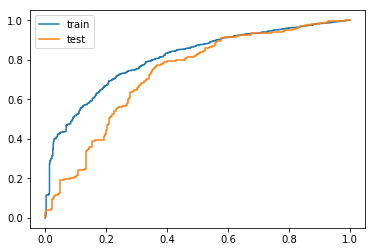

In [67]:
#Logistic Regression
fpr, tpr, threshold = roc_curve(y_train, log_reg.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, label='train')
fpr, tpr, threshold = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='test')
plt.legend()

In [68]:
roc_auc_score(model_results.actuals.values, model_results.probabilities.values)

0.7281614828685958

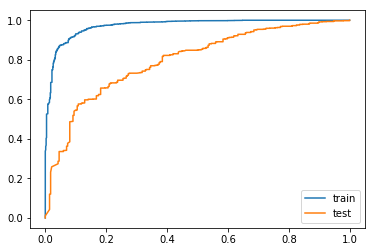

In [69]:
#Gradient Boost
fpr, tpr, threshold = roc_curve(y_train, gb.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, label='train')

fpr, tpr, threshold = roc_curve(y_test, gb.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='test')

plt.legend()

In [70]:
roc_auc_score(model_results_gb.actuals.values, model_results_gb.probabilities.values)

0.7963579307721567

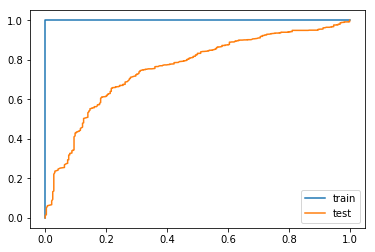

In [71]:
#RandomForest
fpr, tpr, threshold = roc_curve(y_train, rf.predict_proba(X_train)[:, 1])
plt.plot(fpr, tpr, label='train')
fpr, tpr, threshold = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='test')
plt.legend()

In [72]:
roc_auc_score(model_results_rf.actuals.values, model_results_rf.probabilities.values)

0.7590704274804693

## Profic Curves

### Logistic Regression

In [73]:
model_results['category'] = 'Other'

In [74]:
model_results.loc[(model_results.predictions == True) & (model_results.actuals == True),'category'] = 'TP'
model_results.loc[(model_results.predictions == True) & (model_results.actuals == False),'category'] = 'FP'
model_results.loc[(model_results.predictions == False) & (model_results.actuals == False),'category'] = 'TN'
model_results.loc[(model_results.predictions == False) & (model_results.actuals == True),'category'] = 'FN'
model_results.head()

,probabilities,predictions,actuals,ids,category
0,0.692348,1.0,1.0,690509.0,TP
1,0.684633,1.0,0.0,244733.0,FP
2,0.682212,1.0,1.0,330730.0,TP
3,0.694639,1.0,0.0,865720.0,FP
4,0.706668,1.0,0.0,865720.0,FP


In [75]:
pd.DataFrame(model_results.category.value_counts())

,category
TP,956
FP,283
TN,3


### GB

In [76]:
model_results_gb['category'] = 'Other'

In [77]:
model_results_gb.loc[(model_results_gb.predictions == True) & (model_results_gb.actuals == True),'category'] = 'TP'
model_results_gb.loc[(model_results_gb.predictions == True) & (model_results_gb.actuals == False),'category'] = 'FP'
model_results_gb.loc[(model_results_gb.predictions == False) & (model_results_gb.actuals == False),'category'] = 'TN'
model_results_gb.loc[(model_results_gb.predictions == False) & (model_results_gb.actuals == True),'category'] = 'FN'
model_results_gb.head()

,probabilities,predictions,actuals,ids,category
0,0.470937,0.0,1.0,690509.0,FN
1,0.593508,1.0,0.0,244733.0,FP
2,0.787658,1.0,1.0,330730.0,TP
3,0.497067,0.0,0.0,865720.0,TN
4,0.503570,1.0,0.0,865720.0,FP


In [78]:
pd.DataFrame(model_results_gb.category.value_counts())

,category
TP,917
FP,208
TN,78
FN,39


### Random Forest

In [79]:
model_results_rf['category'] = 'Other'

In [80]:
model_results_rf.loc[(model_results_rf.predictions == True) & (model_results_rf.actuals == True),'category'] = 'TP'
model_results_rf.loc[(model_results_rf.predictions == True) & (model_results_rf.actuals == False),'category'] = 'FP'
model_results_rf.loc[(model_results_rf.predictions == False) & (model_results_rf.actuals == False),'category'] = 'TN'
model_results_rf.loc[(model_results_rf.predictions == False) & (model_results_rf.actuals == True),'category'] = 'FN'
model_results_rf.head()

,probabilities,predictions,actuals,ids,category
0,0.557,1.0,1.0,690509.0,TP
1,0.648,1.0,0.0,244733.0,FP
2,0.684,1.0,1.0,330730.0,TP
3,0.501,1.0,0.0,865720.0,FP
4,0.520,1.0,0.0,865720.0,FP


In [81]:
model_results_rf.shape

(1242, 5)

In [82]:
pd.DataFrame(model_results_rf.category.value_counts())

,category
TP,883
FP,206
TN,80
FN,73


In [83]:
cb_matrix = pd.DataFrame([[-5., -20.], [5., 10.]], columns=['PP', 'PN'], index=['AP', 'AN'])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'

In [84]:
cb_matrix = pd.DataFrame([1., 2., 3., 4.], columns=["category"], index=["TP", "TN", "FP", "FN"])

In [85]:
cb_matrix

,category
TP,1.0
TN,2.0
FP,3.0
FN,4.0


## Clustering

In [86]:
import itertools
import scipy.stats as scs
#from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from src.cluster_generators import make_gaussian_clusters
from src.multihist import multihist
from src.silhouette import make_silhouette_plot

In [87]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
X['Account_ID'] = X['Account_ID'].apply(
    lambda x: x.replace('-', '') if isinstance(x, str) else x
).astype(int)

In [89]:
km = KMeans(5)
km.fit(X_train[['Qty', 'Unit_Price']])
labels = km.predict(X_train[['Qty', 'Unit_Price']])

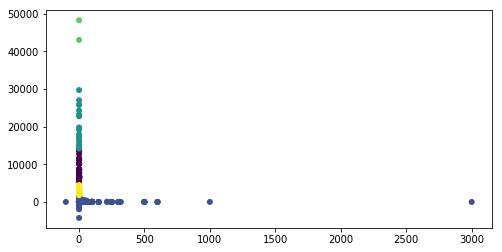

In [90]:
fig, ax = plt.subplots(figsize=(8, 4))

#ax.axis('off')
#ax.axis('equal')
ax.scatter(X_train.values[:,0], X_train.values[:,1], c=labels, linewidths=0)

plt.show()

### Feature importance

In [106]:
ft_imp_df

,Importance
cumulatives,1.484466e-01
CustID,4.496982e-02
Amount,4.150375e-02
Unit_Price,3.825408e-02
Hits,3.310059e-02
Qty,2.283073e-02
Industry_Engineering,1.852348e-02
Topic_PR_3D Printing,1.829056e-02
Month_8,1.208986e-02
City_IRVINE,1.188036e-02


In [107]:
ft_imp_df = pd.DataFrame(index = X_test.columns, data = rf.feature_importances_, columns = ['Importance'])

In [108]:
ft_imp_df = ft_imp_df.sort_values(by=['Importance'], ascending = False)

In [109]:
X_imp = ft_imp_df.index[:15]

In [110]:
y_imp = ft_imp_df.values[:15]

No handles with labels found to put in legend.


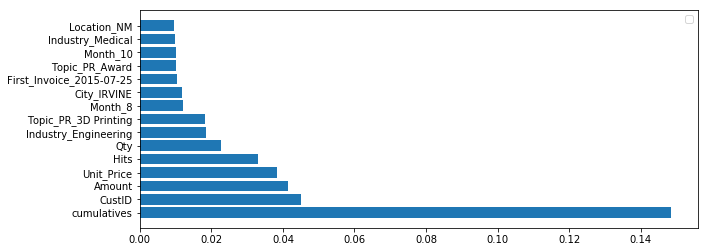

In [111]:
fig, ax = plt.subplots(figsize=(10,4))
ax.barh(X_imp, y_imp.reshape(-1))
ax.legend()

In [96]:
#rf.feature_importances_

In [97]:
from sklearn.linear_model import Lasso

In [98]:
lasso_regularization_strengths = np.logspace(np.log10(0.00001), np.log10(10), num=100)

lasso_regressions = []
for alpha in lasso_regularization_strengths:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    lasso_regressions.append(lasso)



/Users/lulu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lulu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lulu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/lulu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not conver

In [99]:
def plot_solution_paths(ax, regressions, columns):
    alphas = [np.log10(ridge.alpha) for ridge in regressions]
    coeffs = np.concatenate([ridge.coef_.reshape(1, -1) 
                             for ridge in regressions])
    for i,idx in enumerate(range(coeffs.shape[1])):
        name = columns[i]
        ax.plot(alphas, coeffs[:, idx], label = name)
    ax.set_xlabel(r"$\log_{10}(\alpha)$")
    ax.set_ylabel("Estiamted Coefficient")
    ax.set_title("Coefficient Paths")
    ax.legend(loc = 5)

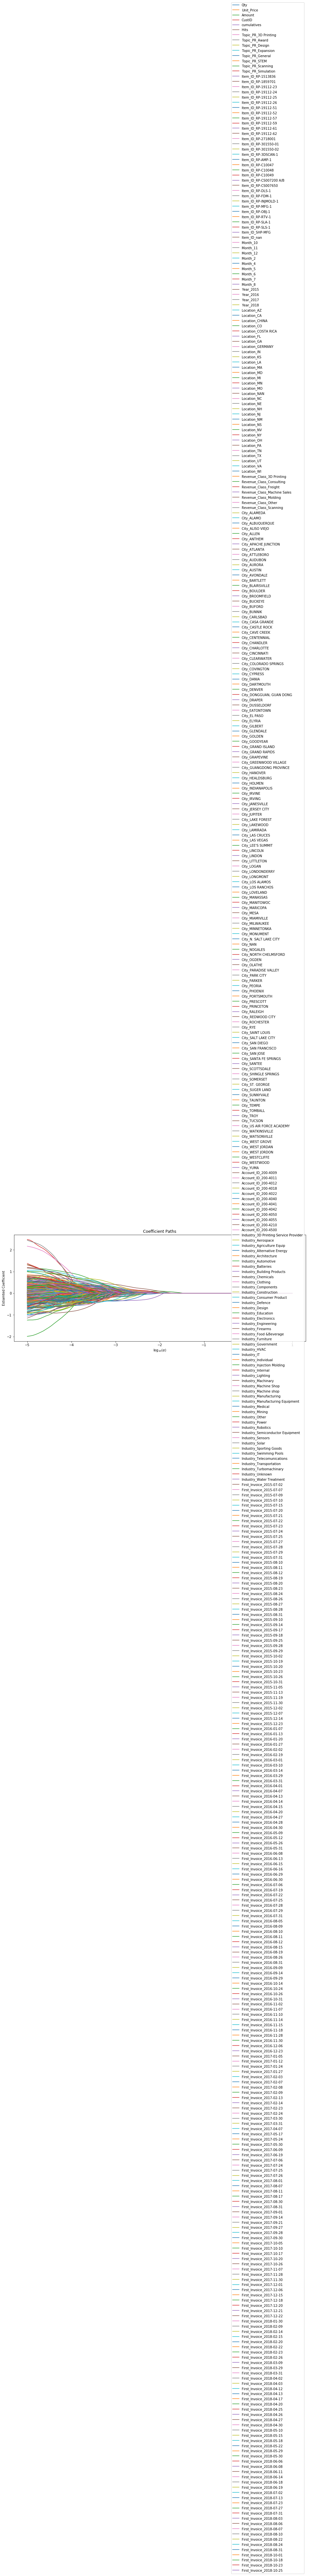

In [100]:
columns = list(X_train.columns)
fig, ax = plt.subplots(figsize=(16, 6))
plot_solution_paths(ax, lasso_regressions, columns)

In [101]:
# Get Feature Importance
coefs = []
for reg in lasso_regressions:
    coefs.append(reg.coef_)
coefs = pd.DataFrame(coefs)
coefs.columns = list(X_train.columns)
np.sum(np.round(np.abs(coefs),3) > 0,axis = 0).sort_values(ascending = False)

First_Invoice_2015-07-25                 54
City_TEMPE                               52
Industry_Engineering                     51
First_Invoice_2015-07-23                 51
Industry_Medical                         50
First_Invoice_2015-07-07                 49
First_Invoice_2017-06-19                 49
Industry_3D Printing Service Provider    49
Month_7                                  49
City_MESA                                48
First_Invoice_2015-07-29                 47
First_Invoice_2015-08-24                 47
City_IRVINE                              45
City_GILBERT                             45
City_ALAMO                               45
Location_NM                              45
First_Invoice_2015-07-10                 44
Month_10                                 44
Industry_Manufacturing                   43
First_Invoice_2015-07-31                 43
Account_ID_200-4050                      42
Item_ID_RP-SLA-1                         42
First_Invoice_2015-09-18        

/Users/lulu/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


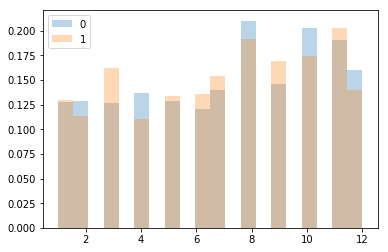

In [102]:
fig, ax = plt.subplots()
ax.hist(X.loc[y==0,'Month'], bins=20, alpha=0.3, label='0', normed=True)
ax.hist(X.loc[y==1,'Month'], bins=20, alpha=0.3, label='1', normed=True)
ax.legend()

In [103]:
#y == 0

In [104]:
#coefs